In [ ]:
# import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, Layer,Bidirectional,GRU,LSTM,Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [ ]:
# Load dataset
data = pd.read_csv("/content/dataset_full (1).csv")
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Preprocessing
data = data.dropna().drop_duplicates()
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)

In [ ]:
# === Train-test split ===
X = data.drop(columns=['phishing'])
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape input for RNNs
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# === Neural Field Attention Layer ===
class NeuralFieldAttention(Layer):
    def __init__(self, timesteps=3, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super(NeuralFieldAttention, self).build(input_shape)

    def call(self, inputs):
        I = inputs
        u = tf.zeros_like(I)

        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)
            activation = tf.nn.relu(u)
            delta = tf.reduce_mean(tf.abs(I - tf.reduce_mean(I, axis=1, keepdims=True)), axis=-1, keepdims=True)
            delta = tf.tile(delta, [1, 1, inputs.shape[-1]])
            u = u + (-u + interaction + I + self.lambda_strength * delta)

        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * inputs, axis=1)
        return attended_output

    def get_config(self):
        config = super(NeuralFieldAttention, self).get_config()
        config.update({
            'timesteps': self.timesteps,
            'lambda_strength': self.lambda_strength
        })
        return config

In [ ]:
# # === Build BiLSTM + GRU + Neural Field Attention Model ===
# model = Sequential()

# # BiLSTM Layer
# model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.3))

# # GRU Layer
# model.add(GRU(32, return_sequences=True))
# model.add(Dropout(0.3))

# # Directly apply Neural Field Attention (no reshape)
# model.add(NeuralFieldAttention(timesteps=5, lambda_strength=0.2))

# # Fully connected layers
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

# # Output layer
# model.add(Dense(1, activation='sigmoid'))

# === Build BiLSTM + GRU + Neural Field Attention Model ===
model = Sequential()

# BiLSTM Layer
model.add(Bidirectional(LSTM(16, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))

# GRU Layer
model.add(GRU(16, return_sequences=True))
model.add(Dropout(0.3))

# Directly apply Neural Field Attention (no reshape)
model.add(NeuralFieldAttention(timesteps=3, lambda_strength=0.2))

# Fully connected layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 111, 32)             │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 111, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 111, 16)             │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 111, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention_1             │ (None, 16)                  │             256 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === Callbacks ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)

In [ ]:
# === Train the Model ===
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, time_callback],
                    verbose=1)

Epoch 1/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - AUC: 0.8931 - Precision: 0.7187 - Recall: 0.8986 - accuracy: 0.8428 - loss: 0.3895Epoch 1 Time: 260.60s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 261s 230ms/step - AUC: 0.8931 - Precision: 0.7187 - Recall: 0.8986 - accuracy: 0.8428 - loss: 0.3895 - val_AUC: 0.9225 - val_Precision: 0.7301 - val_Recall: 0.9749 - val_accuracy: 0.8652 - val_loss: 0.3041
Epoch 2/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - AUC: 0.9160 - Precision: 0.7246 - Recall: 0.9724 - accuracy: 0.8617 - loss: 0.3108Epoch 2 Time: 227.14s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 227s 198ms/step - AUC: 0.9160 - Precision: 0.7246 - Recall: 0.9724 - accuracy: 0.8617 - loss: 0.3108 - val_AUC: 0.9272 - val_Precision: 0.7311 - val_Recall: 0.9744 - val_accuracy: 0.8657 - val_loss: 0.3100
Epoch 3/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - AUC: 0.9138 - Precision: 0.7278 - Recall: 0.9709 - accuracy: 0.8615 - loss: 0.3152Epoch 3 Time: 202.72s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 203s 144m

In [ ]:
# === Evaluate ===
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step

Metrics:
Accuracy: 0.9225
Precision: 0.8941
Recall: 0.8829
AUC: 0.9133
Confusion Matrix:
[[10705   638]
 [  714  5385]]


In [ ]:
# FAR & FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


FAR: 0.0562
FRR: 0.1171


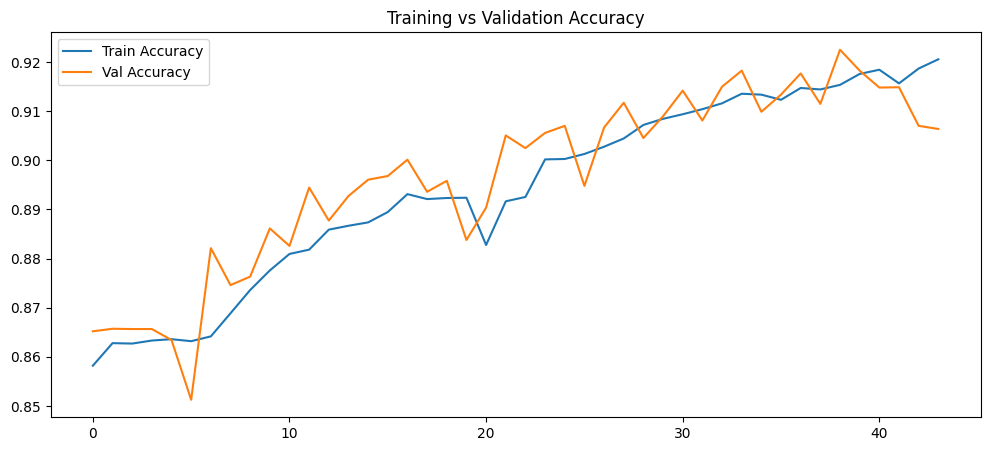

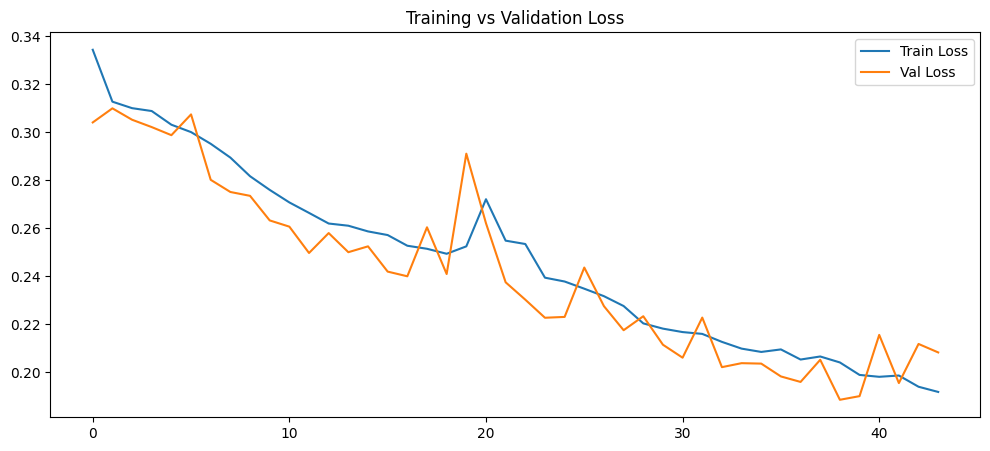

In [ ]:
# === Save History + Plot ===
np.save("model_history_bilstm_gru_nfa.npy", history.history)

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()